In [2]:
import pickle 
from tqdm import tqdm
import math, numpy as np, sympy as sp


def solve_eta2_minus_4zeta3(c1, c2, a1, a2, *, return_poly=False, rtol=1e-10):
    """
    Solve  η(z)^2 - 4·ζ(z)^3 = 0 for z.

    Parameters
    ----------
    c1, c2, a1, a2 : float
        Model parameters.
    return_poly : bool, default False
        If True, also return the numpy.poly1d object for the degree-6 polynomial.
    rtol : float, default 1e-10
        Tolerance for discarding tiny imaginary parts when a root is (numerically) real.

    Returns
    -------
    roots : ndarray
        Array of complex roots.  Roots whose imaginary part is |Im| < rtol are
        returned as real numbers.
    poly  : numpy.poly1d, optional
        Returned only if `return_poly` is True.
    """
    # Declare the indeterminate z
    z = np.poly1d([1.0, 0.0])          # represents the polynomial “z”

    # --- building blocks ----------------------------------------------------
    g0 = -1

    g1 = -z + (1 - c1) * a1 - (1 - c2) * a2

    g2 = (c2 * a2 - c1 * a1) * z + (c1 * c2 - c1 - c2) * a1 * a2

    g3 = c1 * c2 * a1 * a2 * z

    zeta = g2**2 - 3 * g1 * g3                      # quadratic in z
    eta  = 2 * g2**3 - 9 * g1 * g2 * g3 + 27 * g0 * g3**2   # cubic in z

    # Target polynomial of (max) degree 6
    poly = eta**2 - 4 * zeta**3

    # Extract coefficients (highest power first) and drop leading zeros, if any
    coeffs = np.trim_zeros(poly.c, trim='f')

    # Solve
    roots = np.roots(coeffs)

    # Cast very-nearly-real roots to float
    roots = np.array([root.real if abs(root.imag) < rtol else root for root in roots])

    return (roots, poly) if return_poly else roots



def _dnum_poly_L1(c, Delta, branch):
    """
    Return a SymPy Poly in ω whose roots are the stationary points of
    the map ω ↦ x(ω) corresponding to the chosen ± branch.

    The square root is eliminated algebraically, so the polynomial
    has *numeric* coefficients – no radicals left – and can be passed
    safely to `numpy.roots`.
    """
    ω = sp.symbols('omega')
    rad = 1 + 4*ω*(ω + Delta)
    s = sp.symbols('s')                       # placeholder for √rad

    # x(ω) for the indicated sign of the square‑root
    xω = 1/(c*(1-ω)) + (1 + branch*sp.sqrt(rad))/(2*ω)

    # ∂x/∂ω  ⇒  numerator / denominator
    num, den = sp.together(sp.diff(xω, ω)).as_numer_denom()

    # Replace √rad → s, build conjugate, multiply and clean
    num_s   = num.subs(sp.sqrt(rad),  s)
    num_con = num_s.subs(s, -s)
    expr    = sp.expand(num_s * num_con)          # now even in s
    expr    = expr.subs({s**2: rad})              # eliminate s²
    expr    = expr.subs(s, 0)                     # kill leftover s

    return sp.Poly(sp.expand(expr), ω)            # *pure* polynomial


def _density_L1(c, Delta, x):
    """Return limiting density ρ(x) via the imaginary part of ω(x+i0⁺)."""
    a4 = 4*(x**2 - 1)
    a3 = (-4*Delta*c - 8*c*x**2 - 4*c*x + 8*c + 8*x)/c
    a2 = (8*Delta*c**2 + 4*c**2*x**2 + 8*c**2*x - 4*c**2
          - 8*c*x - 4*c + 4)/c**2
    a1 = (-4*Delta*c - 4*c*x + 4)/c
    coeffs = [a4, a3, a2, a1, 0.0]
    roots  = np.roots(coeffs)
    # pick physical root (Im ω > 0 in upper half‑plane)
    phys   = [z for z in roots if z.imag > 1e-9]
    ω      = phys[0] if phys else sorted(roots, key=lambda z: abs(z.imag))[0]
    return ω.imag / math.pi


def spectral_edges_L1(c, p_plus, tol=1e-8, ε=1e-3):
    """
    Return the ordered list of endpoints of the limiting spectrum of
    X = D + W Wᵀ for given aspect ratio c=M/N and spin fraction p_plus.
    If the list has length 2 → one band; length 4 → two bands.
    """
    Δ = 2*p_plus - 1
    xs = set()

    for branch in (+1, -1):
        poly = _dnum_poly_L1(c, Δ, branch)
        coeffs = [complex(co.evalf()) for co in poly.all_coeffs()]
        # strip leading ~0’s so numpy.roots behaves
        while coeffs and abs(coeffs[0]) < tol:
            coeffs.pop(0)
        if len(coeffs) <= 1:          # constant → no roots
            continue
        for ω in np.roots(coeffs):
            if abs(ω.imag) < 1e-9:    # we only keep *real* ω
                ω = ω.real
                if abs(ω) < tol or abs(1-ω) < tol:
                    continue          # singular map ω↦x
                rad = 1 + 4*ω*(ω + Δ)
                if rad < 0:
                    continue          # branch‑cut: x(ω) complex
                x = 1/(c*(1-ω)) + (1 + branch*math.sqrt(rad))/(2*ω)
                if math.isfinite(x):
                    xs.add(x)

    # Filter candidate x’s: density jumps from 0 to >0
    edges = []
    for x in sorted(xs):
        ρL = _density_L1(c, Δ, x - ε)
        ρR = _density_L1(c, Δ, x + ε)
        if (ρL < tol < ρR) or (ρR < tol < ρL):
            edges.append(float(x))
    return edges



In [3]:
from manim import *

/Users/ninou/anaconda3/lib/python3.9/site-packages/manim/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Manim Community v0.17.3

In [4]:
with open('eigvals_data_L1_200M.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
    
(AH_L1_frac_list,AH_L1_upper_frac_list, c_list, N_list, max_eigvals_tens) = loaded_data

## for L2

In [6]:
M = 1000
#N = 2000
nb_AH_L1 = 0

nb_c = 500
nb_AH_range = 500


mask_mat_all_stable_L2 = np.zeros((nb_c , nb_AH_range))
mask_mat_some_stable_L2 = np.zeros((nb_c , nb_AH_range))


init_scale = 0.1

AH_L2_frac_list = np.zeros(nb_c)
AH_L2_upper_frac_list = np.zeros(nb_c)

max_eigvals_tens = np.zeros((nb_c, nb_AH_range))

c_list_L2 = np.logspace(-3,2, num = nb_c)
N_list = np.array(M/c_list_L2, dtype = 'int')


for k in tqdm(range(nb_c)):
    N = N_list[k]
    small_root_list = []
    for nb_AH_L2 in np.linspace(1,N-1,num = nb_AH_range, dtype = 'int'):
        
        #nb_AH_L2 = nb_AH_L2.item()
        a1 = init_scale**2*(N-nb_AH_L2)/M
        a2 = init_scale**2*nb_AH_L2/M
        c1 = M/(N-nb_AH_L2)
        c2 = M/nb_AH_L2
        roots = solve_eta2_minus_4zeta3(c1.item(), c2.item(), a1.item(), a2.item())
        sort_roots = np.sort(roots)
        small_root_list.append(sort_roots[0:2])

    small_root_list = -init_scale**2-np.real(np.array(small_root_list))
    highest_root_list = small_root_list[:,0]
    lower_root_list = small_root_list[:,1]
    
    mask_above = highest_root_list > 0
    mask_mat_all_stable_L2[k] = mask_above
    if np.any(mask_above):
        idx      = mask_above.argmax()         # first True index
        x_cross  = (idx)/N
    else :
        x_cross = 1

    AH_L2_frac_list[k] = x_cross
    
    
    mask_above_upper = lower_root_list >0
    mask_mat_some_stable_L2[k] = mask_above_upper
    if np.any(mask_above_upper):
        idx_upper = mask_above_upper.argmax()
        x_cross_upper = idx_upper/N
    else :
        x_cross_upper = 1
    AH_L2_upper_frac_list[k] = x_cross_upper

100%|██████████| 500/500 [00:44<00:00, 11.32it/s]


In [7]:
L2_to_save = [mask_mat_all_stable_L2, mask_mat_some_stable_L2, AH_L2_frac_list, AH_L2_upper_frac_list]
L2_results = np.empty(len(L2_to_save), dtype='object')
L2_results[:] = L2_to_save
#np.save('L2_results.npy', L2_results )

## for L1

In [8]:
# ----------------------------------------------------------
# 0. Imports
# ----------------------------------------------------------
import numpy as np
from joblib import Parallel, delayed          #  ← NEW
from tqdm.auto import tqdm                    # nice progress bar

# ----------------------------------------------------------
# 1. Problem parameters
# ----------------------------------------------------------
M        = 500
nb_c     = 500
#c_list_L1 = np.logspace(-3, 2, num=nb_c)
c_list_L1 = np.linspace(0.1,0.7, num=nb_c)
N_list    = np.array(M / c_list_L1, dtype=int)

# pre-allocate output arrays
mask_mat_all_stable  = np.zeros((nb_c, M), dtype=bool)
mask_mat_some_stable = np.zeros((nb_c, M), dtype=bool)
AH_L1_frac_list        = np.zeros(nb_c)
AH_L1_upper_frac_list  = np.zeros(nb_c)

# ----------------------------------------------------------
# 2. Helper executed in parallel
# ----------------------------------------------------------
def _process_single_c(k, c, M):
    """
    Compute stability masks and crossing points for one value of c.
    Returns
    -------
    (mask_all, mask_some, x_cross, x_cross_upper)
    """
    N = int(M / c)
    highest_root   = np.empty(M)
    lower_root     = np.empty(M)

    # inner loop over number of AH neurons in L1
    for nb_AH_L1 in range(M):
        p1 = (M - nb_AH_L1) / M
        roots = -np.array(spectral_edges_L1(c, p1))   # user-supplied function
        highest_root[nb_AH_L1] = roots[0]
        lower_root[nb_AH_L1]   = roots[1]

    mask_all  = highest_root > 0           # “all remain stable”
    mask_some = lower_root   > 0           # “some remain stable”

    # where does each mask first turn True?
    x_cross        = (mask_all.argmax()   / N) if mask_all.any()  else 1.0
    x_cross_upper  = (mask_some.argmax() / N) if mask_some.any() else 1.0

    return mask_all, mask_some, x_cross, x_cross_upper

# ----------------------------------------------------------
# 3. Run the outer loop in parallel
# ----------------------------------------------------------
results = Parallel(n_jobs=-1, verbose=0)(
            delayed(_process_single_c)(k, c, M)
            for k, c in tqdm(enumerate(c_list_L1), total=nb_c,
                             desc="Computing phase diagram")
          )

# ----------------------------------------------------------
# 4. Unpack the results
# ----------------------------------------------------------
for k, (mask_all, mask_some, xc, xcu) in enumerate(results):
    mask_mat_all_stable[k]  = mask_all
    mask_mat_some_stable[k] = mask_some
    AH_L1_frac_list[k]        = xc
    AH_L1_upper_frac_list[k]  = xcu


Computing phase diagram:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
L1_to_save = [mask_mat_all_stable, mask_mat_some_stable, AH_L1_frac_list, AH_L1_upper_frac_list]
L1_results = np.empty(len(L1_to_save), dtype='object')
L1_results[:] = L1_to_save
#np.save('L1_zoom_results.npy', L1_results )

In [9]:
(mask_mat_all_stable, mask_mat_some_stable, AH_L1_frac_list, AH_L1_upper_frac_list) = np.load('L1_results.npy', allow_pickle=True)
(mask_mat_all_stable_L2, mask_mat_some_stable_L2, AH_L2_frac_list, AH_L2_upper_frac_list) = np.load('L2_results.npy', allow_pickle=True)

M        = 500
nb_c     = 500

c_list_L1 = np.logspace(-3, 2, num=nb_c)
c_list_L2 = np.logspace(-3,2, num = nb_c)


/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_3024/667130235.py:71: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  some_coll = cf_some.collections[1]                    # the /// level
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_3024/667130235.py:71: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  some_coll = cf_some.collections[1]                    # the /// level


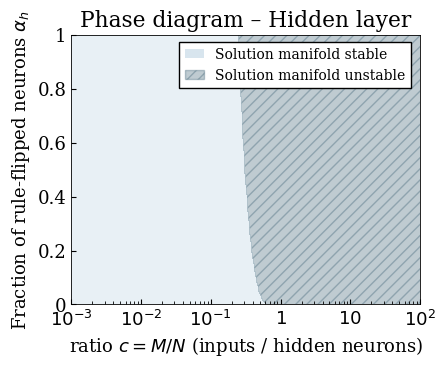

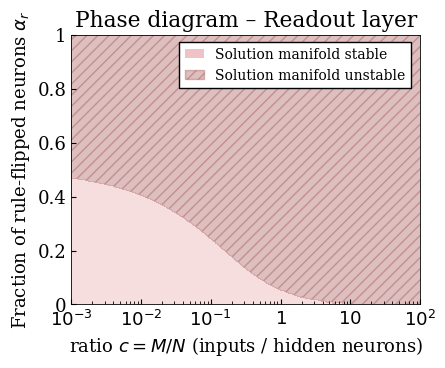

In [11]:
# -------------------------------------------------
# 0. Imports and global style
# -------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import LogLocator   # (not used here but often handy)

rcParams.update({
    "font.family": "serif",
    "font.size": 13,
    "axes.linewidth": 0.6,
    "axes.spines.right": True,
    "axes.spines.top": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

# Same palette you used for the 1-D plots
c1, c2, c3, c4 = '#669BBC', '#C1121F', '#003049', '#780000'

# -------------------------------------------------
# 1.  Re-usable helper to draw a phase diagram
# -------------------------------------------------
def phase_diagram(Z_bool, some_stable_bool,
                  x_vals, y_vals,
                  *,                       # keyword-only from here on
                  title,
                  color_all, color_some,
                  xlabel=r"ratio $c=M/N$ (inputs / hidden neurons)",
                  ylabel=r"$i$ index",
                  figsize=(4.5, 3.5)):
    """
    Parameters
    ----------
    Z_bool          (nx, ny) bool – True where *all* solutions remain stable
    some_stable_bool          – True where *some* solutions remain stable
    x_vals          (nx,) 1-D – coordinates along x (e.g. c_list_L1)
    y_vals          (ny,) 1-D – coordinates along y
    title           str     – figure title
    color_all       str/hex – colour for “all solutions stable”
    color_some      str/hex – colour for “some solutions stable”
    """
    # ---------- numeric masks ----------
    Z     = Z_bool.astype(int)                            # 1 = all stable
    Y     = 1-Z# * (1 - some_stable_bool.astype(int))        # 1 = some stable
    NOSOL = Y - Z + 1                                     # 1 = none stable

    # mesh for proper data coordinates
    X, Ygrid = np.meshgrid(x_vals, y_vals, indexing='ij')

    fig, ax = plt.subplots(figsize=figsize)

    # ---------- layer 1 : ALL solutions stable ----------
    ax.contourf(X, Ygrid, Z,
                levels=[-0.5, 0.5, 1.5],
                colors=[color_all, "white"],
                alpha=0.25, hatches=['', '']  )

    # ---------- layer 2 : SOME solutions stable ----------
    cf_some = ax.contourf(X, Ygrid, Z ,
                          levels=[-0.5, 0.5, 1.5],
                          colors=["white", color_some],
                          alpha=0.25, hatches=['', '///']  )
    
    #cf_some.collections[1].set_edgecolor(mcolors.to_rgba(color_some, 1))
    #cf_some.collections[1].set_linewidth(0)
   
    # make only the hatch visible – no filled face
    some_coll = cf_some.collections[1]                    # the /// level
    some_coll.set_facecolor('none')                       # keep hatch, drop fill
    some_coll.set_edgecolor(mcolors.to_rgba(color_some,1))  # hatch colour
    some_coll.set_linewidth(0)
    


    # 2a – keep the translucent coloured fill (no hatch)
    ax.contourf(X, Ygrid,  Z ,
                levels=[-0.5, 0.5, 1.5],
                colors=["white", color_some], alpha=0.25)

    # 2b – overlay *only* the hatch, facecolourless and opaque
    #cs_hatch = ax.contourf(X, Ygrid, Z * (1 - some_stable_bool.astype(int)),
    #                       levels=[-0.5, 0.5, 1.5],
    #                       colors="none",           # <- nothing to fill
    #                       hatches=["", "///"])
    #for coll in cs_hatch.collections[1:]:
    #    coll.set_edgecolor(mcolors.to_rgba(color_some,0.2))  # colour of the hatch
    #    coll.set_linewidth(0)



    # ---------- axes cosmetics ----------
    ax.set_xscale("log")
    xticks = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
    ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,)))
    ax.set_xticks(xticks)
    ax.set_xticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$",
                        r"$1$", r"$10$", r"$10^{2}$"])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_aspect("auto")          # square isn’t appropriate for unequal scales

    # ---------- legend (matches 1-D plots) ----------
    legend_handles = [
        mpatches.Patch(facecolor=color_all, edgecolor='none',
                       alpha=0.25, label="Solution manifold stable"),
        mpatches.Patch(facecolor=color_some, edgecolor=color_some,
                       alpha=0.25, hatch='///', label="Solution manifold unstable"),

    ]
    ax.legend(handles=legend_handles,
              frameon=True, facecolor="white", edgecolor="k",
              fancybox=False, framealpha=1,
              fontsize=10, handlelength=1.4,
              bbox_to_anchor=(0.29, 1), loc="upper left")

    return fig, ax

def relabel_y_as_fraction(ax, full_range, n_ticks=6):
    """
    Show the y-axis as 0→1 while keeping the original data range.

    Parameters
    ----------
    ax          : matplotlib Axes  – the axis to modify
    full_range  : float/int        – top of the raw y-axis (bottom is assumed 0)
    n_ticks     : int              – how many major ticks to place (default 5)
    """
    tick_positions = np.linspace(0, full_range, n_ticks)
    tick_labels    = np.linspace(0, 1, n_ticks)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{t:.2g}" for t in tick_labels])

# ------------------------------------------------------------
#  L1 phase diagram
# ------------------------------------------------------------
fig_L1, ax_L1 = phase_diagram(mask_mat_all_stable,
                              mask_mat_some_stable,
                              x_vals=c_list_L1,
                              y_vals=np.arange(mask_mat_all_stable.shape[1]),
                              title="Phase diagram – Hidden layer",
                              color_all=c1,
                              color_some=c3)

ax_L1.set_ylabel(r"Fraction of rule-flipped neurons $\alpha_h$")
relabel_y_as_fraction(ax_L1, full_range=mask_mat_all_stable.shape[1]-1)

# ------------------------------------------------------------
#  L2 phase diagram
# ------------------------------------------------------------
fig_L2, ax_L2 = phase_diagram(mask_mat_all_stable_L2,
                              mask_mat_some_stable_L2,
                              x_vals=c_list_L2,
                              y_vals=np.arange(mask_mat_all_stable_L2.shape[1]),
                              title="Phase diagram – Readout layer",
                              color_all=c2,
                              color_some=c4)

ax_L2.set_ylabel(r"Fraction of rule-flipped neurons $\alpha_r$")
relabel_y_as_fraction(ax_L2, full_range=mask_mat_all_stable_L2.shape[1]-1)

#plt.savefig("AH_fraction_vs_ratio.pdf", dpi=300, bbox_inches = 'tight')
#fig_L1.savefig("L1_AH_fraction_vs_ratio_new.pdf", dpi=300, bbox_inches = 'tight')
#fig_L2.savefig("L2_AH_fraction_vs_ratio_new.pdf", dpi=300, bbox_inches = 'tight')
#fig_L1.savefig("L1_AH_fraction_vs_ratio_new.svg", dpi=300, bbox_inches = 'tight')
#fig_L2.savefig("L2_AH_fraction_vs_ratio_new.svg", dpi=300, bbox_inches = 'tight')
